In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gdp
import pygeos
import rtree
import seaborn as sns

/Users/nicha/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Data Preprocessing

### KNNImputer 


In [2]:
df = gdp.read_file("../raw_data/final_data/full.shp")

In [3]:
df.columns

Index(['E_E', 'E_EM', 'E_EW', 'E_EU1', 'E_E1U6', 'E_E6U15', 'E_E15U18',
       'E_E18U25', 'E_E25U55', 'E_E55U65', 'E_E65U80', 'E_E80U110', 'MH_E',
       'MH_EM', 'MH_EW', 'MH_U1', 'MH_1U6', 'MH_6U15', 'MH_15U18', 'MH_18U25',
       'MH_25U55', 'MH_55U65', 'MH_65U80', 'MH_80U110', 'angebotsmi',
       'aenderung_', 'anteil_lei', 'anteil_soz', 'anteil_sta', 'entwicklun',
       'wohndauer', 'wohnungsum', 'wohnungs_1', 'wohnungsve', 'wohnungs_2',
       'Nummer', 'Name', 'EW', 'ant_arbeit', 'ant_transf', 'Kinderarmu',
       'ant_arbe_1', 'ant_tran_1', 'Kinderar_1', 'BEZ', 'PLR_ID', 'MH_rate',
       'area', 'pop_dens', 'BZR_ID', 'PGR_ID', 'bis_1900', 'x1901_1910',
       '1911-1920', '1921-1930', '1930-1940', '1941_1950', '1951_1960',
       '1961-1970', '1971-1980', '1980-1990', '1991-2000', '2001-2010',
       '2010-2015', 'ew2015', 'index_left', 'laerm', 'luft', 'gruen', 'bio',
       'mobility_p', 'mobility_b', 'mobility_1', 'spaces_gre', 'spaces_wat',
       'social_com', 'social_

##alternative with the SimpleImputer_module
-import the imputer
from sklearn.impute import SimpleImputer
- Instantiate most frequent imputer
feature_imputer = SimpleImputer(strategy="most_frequent")
- Fit imputer to enginelocation column
feature_imputer.fit(df[['feature']])
- Impute
df[['feature']] = feature_imputer.transform(df[['feature']])

In [4]:
# import the imputer
from sklearn.impute import KNNImputer
# Instantiate most frequent imputer
feature_imputer = KNNImputer(missing_values= np.nan)
#features on map
featuresonmap = df[['mobility_p', 'mobility_b', 'mobility_1', 'spaces_gre', 'spaces_wat',
       'social_com', 'social_cul', 'social_eat', 'social_nig', 'activities',
       'activiti_1', 'activiti_2', 'activiti_3']]
# Fit imputer to enginelocation column
feature_imputer.fit(df[['mobility_p', 'mobility_b', 'mobility_1', 'spaces_gre', 'spaces_wat',
       'social_com', 'social_cul', 'social_eat', 'social_nig', 'activities',
       'activiti_1', 'activiti_2', 'activiti_3']])

KNNImputer()

In [5]:
# Impute and round the imputed value!
df[['mobility_p', 'mobility_b', 'mobility_1', 'spaces_gre', 'spaces_wat',
       'social_com', 'social_cul', 'social_eat', 'social_nig', 'activities',
       'activiti_1', 'activiti_2', 'activiti_3']] = np.round(feature_imputer.transform(df[['mobility_p', 'mobility_b', 'mobility_1', 'spaces_gre', 'spaces_wat',
       'social_com', 'social_cul', 'social_eat', 'social_nig', 'activities',
       'activiti_1', 'activiti_2', 'activiti_3']]))
df.spaces_wat.nunique

<bound method IndexOpsMixin.nunique of 0      0.0
1      0.0
2      0.0
3      1.0
4      1.0
      ... 
537    0.0
538    1.0
539    0.0
540    1.0
541    0.0
Name: spaces_wat, Length: 542, dtype: float64>

In [6]:
df.spaces_wat.unique()

array([ 0.,  1.,  4.,  2.,  3.,  9.,  6.,  5., 19., 17., 10.])

In [7]:
social_imputer = KNNImputer(missing_values= np.nan, n_neighbors=4)
#features on map
social_features = df[['ant_arbeit', 'ant_transf', 'Kinderarmu',
       'ant_arbe_1', 'ant_tran_1', 'Kinderar_1']]
# Fit imputer to enginelocation column
social_imputer.fit(df[['ant_arbeit', 'ant_transf','Kinderarmu',
       'ant_arbe_1', 'ant_tran_1', 'Kinderar_1' ]])

KNNImputer(n_neighbors=4)

In [8]:
df[['ant_arbeit', 'ant_transf', 'Kinderarmu',
       'ant_arbe_1', 'ant_tran_1', 'Kinderar_1']] = social_imputer.transform(df[['ant_arbeit', 'ant_transf', 'Kinderarmu',
       'ant_arbe_1', 'ant_tran_1', 'Kinderar_1']])

In [9]:
pd.options.display.max_rows = 550

### Feature selection

1. remove one (corr lower to the target) of the pair thats highest corr
2. also remove the perfectly corr, that have same attribute (DATA LEAKAGE)
3. remove as many feature as you want, starting from those with the highest correlation, until your model performance starts to drop too significantly

<AxesSubplot:>

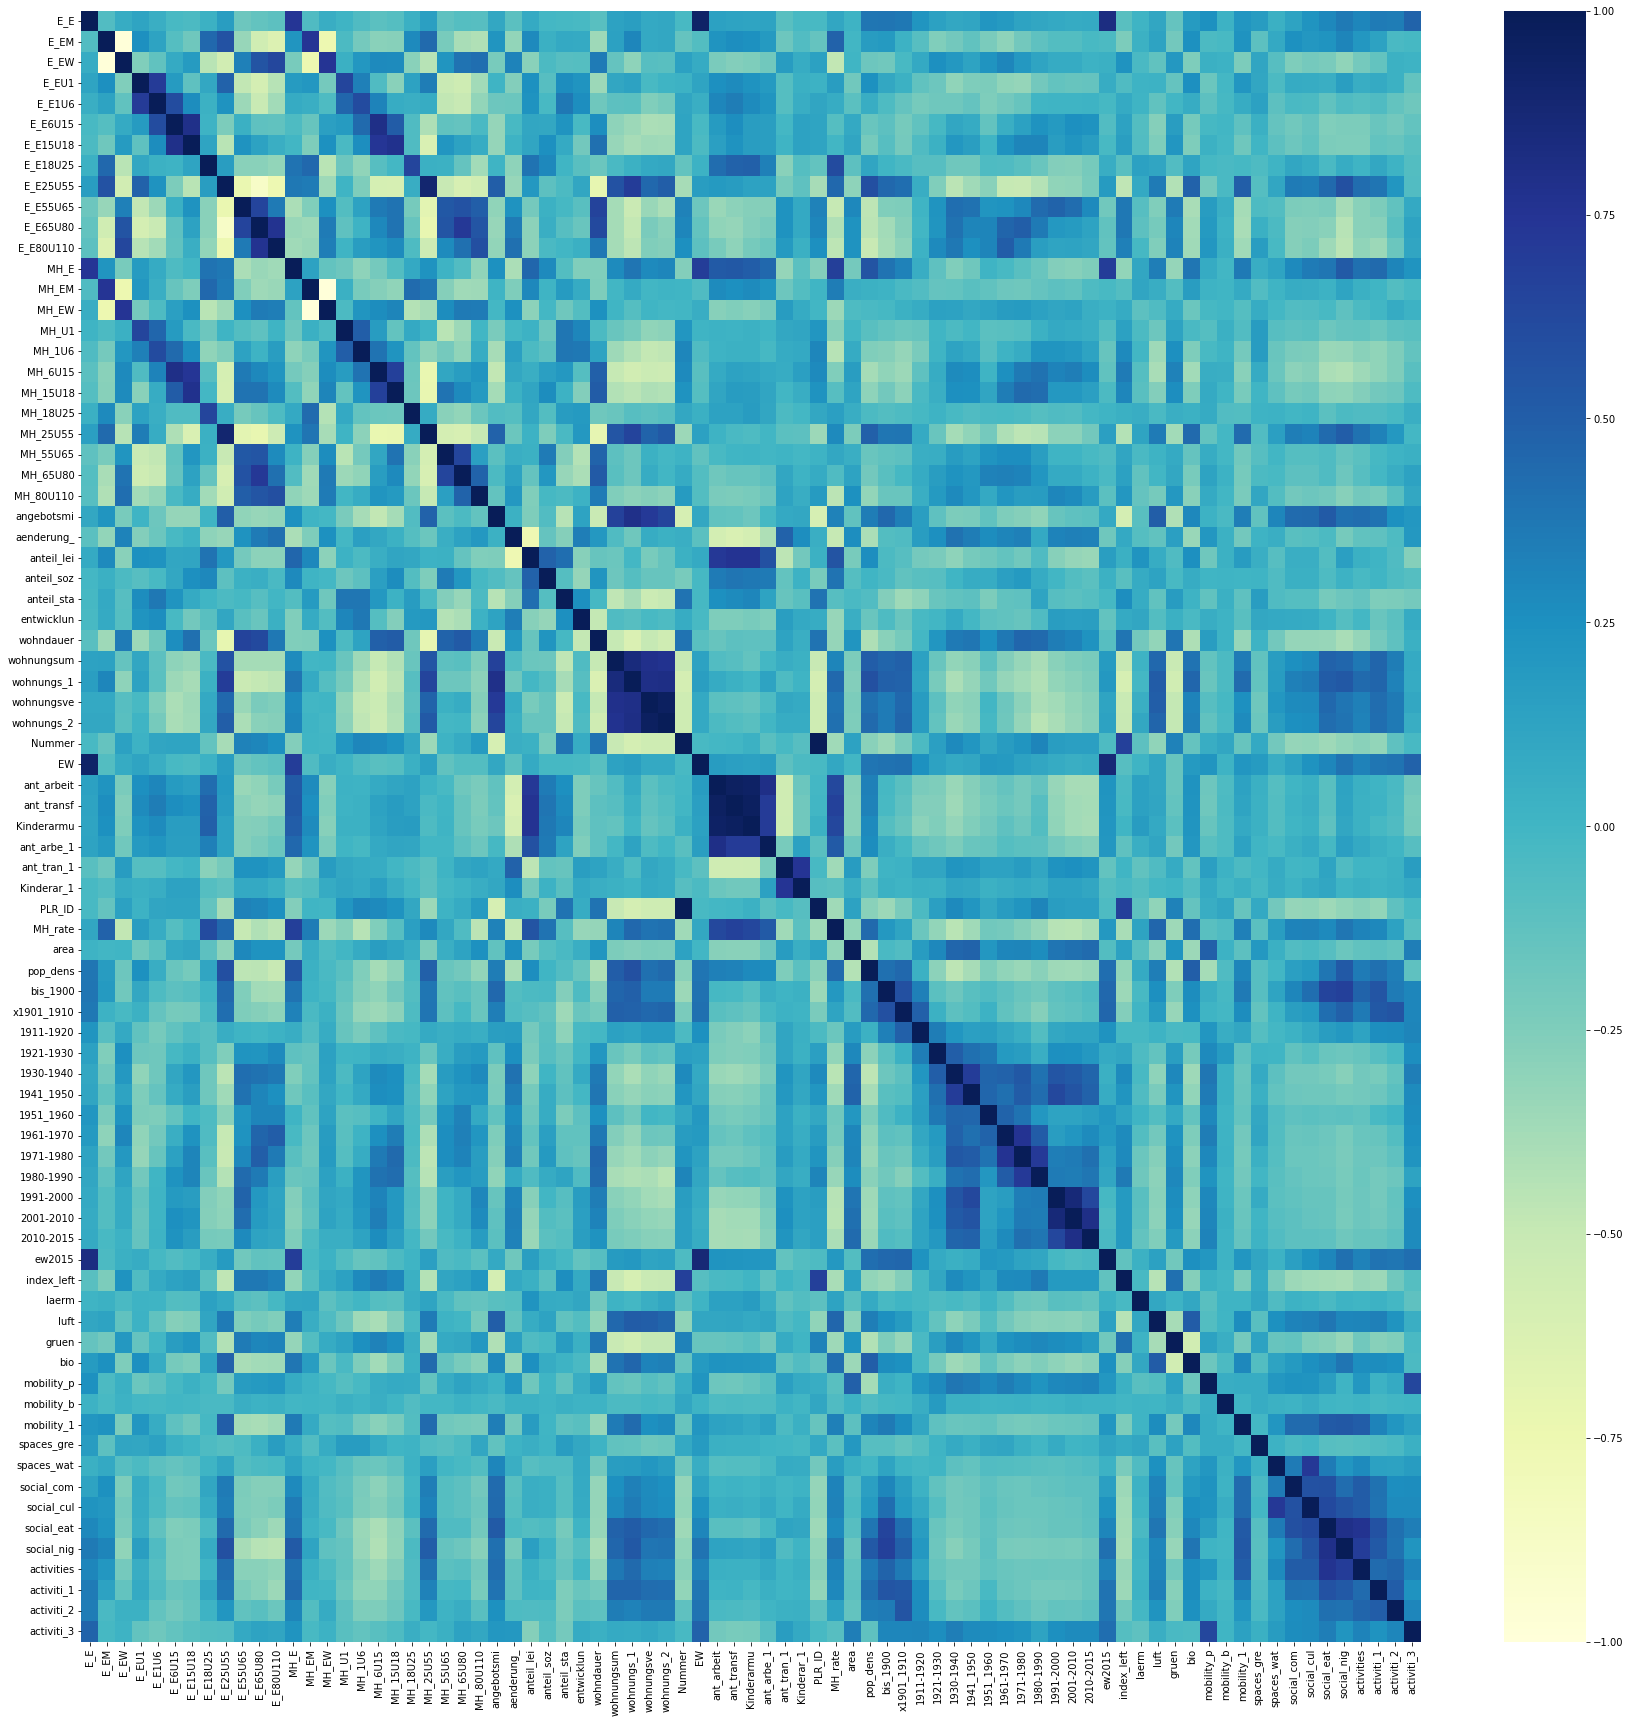

In [10]:
##plot the pearson corr
corr = df.corr()
#plot heatmap
plt.figure(figsize=(30,30))
sns.heatmap(corr, cmap= "YlGnBu")

In [11]:
##create the df of corr_features pairs
#Unstack correlation matrix
corr_df = corr.unstack().reset_index()
#Rename the columns
corr_df.columns = ["feature_1", "feature_2", "correlation"]
#sorted values
corr_df.sort_values(by="correlation", ascending=False, inplace=True)
#remove the self correlation
corr_df = corr_df[corr_df["feature_1"] != corr_df["feature_2"]]

In [12]:
pd.options.display.max_rows = 550

In [13]:
corr_df = corr_df[corr_df["feature_1"] != corr_df["feature_2"]]
corr_df.head(100)

,feature_1,feature_2,correlation
2808,Nummer,PLR_ID,1.000000
3432,PLR_ID,Nummer,1.000000
3119,Kinderarmu,ant_transf,0.967386
3041,ant_transf,Kinderarmu,0.967386
2641,wohnungsve,wohnungs_2,0.964698
2719,wohnungs_2,wohnungsve,0.964698
2961,ant_arbeit,ant_transf,0.956929
3039,ant_transf,ant_arbeit,0.956929
2962,ant_arbeit,Kinderarmu,0.943110
3118,Kinderarmu,ant_arbeit,0.943110


In [14]:
corr_df[corr_df.feature_1 == "Kinderarmu"]

,feature_1,feature_2,correlation
3119,Kinderarmu,ant_transf,0.967386
3118,Kinderarmu,ant_arbeit,0.943110
3107,Kinderarmu,anteil_lei,0.755295
3121,Kinderarmu,ant_arbe_1,0.703712
3125,Kinderarmu,MH_rate,0.639737
3093,Kinderarmu,MH_E,0.504620
3088,Kinderarmu,E_E18U25,0.486926
3108,Kinderarmu,anteil_soz,0.374615
3109,Kinderarmu,anteil_sta,0.297648
3127,Kinderarmu,pop_dens,0.282634


In [15]:
#merge
#bin -
'E_EU1', 'E_E1U6', 'E_E6U15', 'E_E15U18',
'E_E18U25'
'E_E25U55','E_E55U65'
'E_E65U80', 'E_E80U110'
'bis_1900', 'x1901_1910','1911-1920', '1921-1930', '1930-1940'
'1941_1950', '1951_1960','1961-1970', '1971-1980','1980-1990'
'1991-2000', '2001-2010','2010-2015',

('1991-2000', '2001-2010', '2010-2015')

In [16]:
elist = ['E_EU1', 'E_E1U6', 'E_E6U15', 'E_E15U18',
'E_E18U25',
'E_E25U55','E_E55U65',
'E_E65U80', 'E_E80U110']

In [17]:
df.drop(columns=['E_EM', 'E_EW','MH_EM', 'MH_EW', 'MH_U1', 'MH_1U6', 'MH_6U15', 'MH_15U18', 'MH_18U25',
       'MH_25U55', 'MH_55U65', 'MH_65U80', 'MH_80U110','anteil_lei','Nummer', 'Name','EW','BEZ','area','BZR_ID', 'PGR_ID',  'ew2015','index_left','mobility_b', 'mobility_1'], inplace = True)

In [18]:
df.set_index('PLR_ID', inplace = True)


In [19]:
#change name
df.rename(columns={'activities' : "economic",
'activiti_1' :"education",
'activiti_2' : "health_care",
'activiti_3': "public_service"}, inplace=True)


In [20]:
for e in elist:
    df[e] = df[e] * df["E_E"]


In [21]:
df['E_U18'] = df['E_EU1'] + df['E_E1U6'] + df['E_E6U15'] + df['E_E15U18']

In [22]:
df['E_E25U65'] = df['E_E25U55'] + df['E_E55U65']

In [23]:
df['E_E65U110'] =  df['E_E65U80'] + df['E_E80U110']

In [24]:
df.head()

,E_E,E_EU1,E_E1U6,E_E6U15,E_E15U18,E_E18U25,E_E25U55,E_E55U65,E_E65U80,E_E80U110,...,social_eat,social_nig,economic,education,health_care,public_service,geometry,E_U18,E_E25U65,E_E65U110
PLR_ID,,,,,,,,,,,,,,,,,,,,,
11501341,7270.352618,57.395088,416.349168,1001.510202,219.584817,422.736458,3244.499071,896.864662,692.779315,318.633837,...,10.0,1.0,0.0,5.0,6.0,4.0,"POLYGON ((399848.954 5815619.506, 399854.727 5...",1694.839276,4141.363733,1011.413151
3701659,9797.460933,99.629581,570.832234,877.836828,236.534846,560.654742,5886.201184,879.389306,488.550307,197.831905,...,26.0,6.0,4.0,4.0,4.0,5.0,"POLYGON ((393175.012 5821135.577, 393167.174 5...",1784.833490,6765.590490,686.382212
7601340,2037.887335,15.506461,109.212332,169.290563,51.747113,137.161837,723.924260,267.007460,377.812778,186.224532,...,2.0,2.0,2.0,2.0,2.0,4.0,"POLYGON ((388394.110 5807792.070, 388379.276 5...",345.756468,990.931720,564.037310
2500831,6441.757140,77.761704,378.962012,414.772512,95.356547,387.015029,4383.632441,415.718031,226.196198,62.342666,...,14.0,11.0,2.0,8.0,8.0,1.0,"POLYGON ((396010.552 5819339.570, 396021.567 5...",966.852776,4799.350472,288.538864
12601134,14514.988193,134.457162,895.167752,1605.408458,553.583581,1158.356559,5110.541680,1625.830806,2344.805761,1086.836435,...,3.0,1.0,4.0,4.0,3.0,5.0,"POLYGON ((387367.428 5828619.763, 387315.862 5...",3188.616953,6736.372485,3431.642196


In [25]:
df.drop(columns=['E_E','E_EU1', 'E_E1U6', 'E_E6U15', 'E_E15U18','E_E25U55','E_E55U65','E_E65U80', 'E_E80U110'], inplace=True)


In [26]:
df.columns

Index(['E_E18U25', 'MH_E', 'angebotsmi', 'aenderung_', 'anteil_soz',
       'anteil_sta', 'entwicklun', 'wohndauer', 'wohnungsum', 'wohnungs_1',
       'wohnungsve', 'wohnungs_2', 'ant_arbeit', 'ant_transf', 'Kinderarmu',
       'ant_arbe_1', 'ant_tran_1', 'Kinderar_1', 'MH_rate', 'pop_dens',
       'bis_1900', 'x1901_1910', '1911-1920', '1921-1930', '1930-1940',
       '1941_1950', '1951_1960', '1961-1970', '1971-1980', '1980-1990',
       '1991-2000', '2001-2010', '2010-2015', 'laerm', 'luft', 'gruen', 'bio',
       'mobility_p', 'spaces_gre', 'spaces_wat', 'social_com', 'social_cul',
       'social_eat', 'social_nig', 'economic', 'education', 'health_care',
       'public_service', 'geometry', 'E_U18', 'E_E25U65', 'E_E65U110'],
      dtype='object')

In [28]:
df['B_1940'] = df['bis_1900'] + df['x1901_1910'] + df['1911-1920'] + df['1921-1930']+ df['1930-1940']
df['B_1941_1990'] = df['1941_1950'] + df['1951_1960'] + df['1961-1970'] + df['1971-1980'] + df['1980-1990']
df['B_1991_2000'] = df['1991-2000'] + df['2001-2010'] + df['2010-2015'] 

In [29]:
df.drop(columns=['bis_1900','x1901_1910','1911-1920', '1921-1930', '1930-1940',
'1941_1950', '1951_1960','1961-1970', '1971-1980','1980-1990',
'1991-2000', '2001-2010','2010-2015'], inplace=True)

In [31]:
df.columns

Index(['E_E18U25', 'MH_E', 'angebotsmi', 'aenderung_', 'anteil_soz',
       'anteil_sta', 'entwicklun', 'wohndauer', 'wohnungsum', 'wohnungs_1',
       'wohnungsve', 'wohnungs_2', 'ant_arbeit', 'ant_transf', 'Kinderarmu',
       'ant_arbe_1', 'ant_tran_1', 'Kinderar_1', 'MH_rate', 'pop_dens',
       'laerm', 'luft', 'gruen', 'bio', 'mobility_p', 'spaces_gre',
       'spaces_wat', 'social_com', 'social_cul', 'social_eat', 'social_nig',
       'economic', 'education', 'health_care', 'public_service', 'geometry',
       'E_U18', 'E_E25U65', 'E_E65U110', 'B_1940', 'B_1941_1990',
       'B_1991_2000'],
      dtype='object')

In [30]:
df

,E_E18U25,MH_E,angebotsmi,aenderung_,anteil_soz,anteil_sta,entwicklun,wohndauer,wohnungsum,wohnungs_1,...,education,health_care,public_service,geometry,E_U18,E_E25U65,E_E65U110,B_1940,B_1941_1990,B_1991_2000
PLR_ID,,,,,,,,,,,,,,,,,,,,,
11501341,422.736458,1094.074159,9.750001,-0.190001,1.300001,24.830000,10.270005,62.319997,5.910001,43.489997,...,5.0,6.0,4.0,"POLYGON ((399848.954 5815619.506, 399854.727 5...",1694.839276,4141.363733,1011.413151,621.0,73.0,505.0
3701659,560.654742,3292.586618,11.262562,-1.409922,0.390757,12.772029,5.213178,61.167671,29.312730,88.374790,...,4.0,4.0,5.0,"POLYGON ((393175.012 5821135.577, 393167.174 5...",1784.833490,6765.590490,686.382212,236.0,19.0,15.0
7601340,137.161837,812.483121,8.100000,-1.230000,12.719999,26.729999,1.990000,71.059997,1.980000,4.410000,...,2.0,2.0,4.0,"POLYGON ((388394.110 5807792.070, 388379.276 5...",345.756468,990.931720,564.037310,35.0,312.0,57.0
2500831,387.015029,2531.145525,13.970000,-2.040000,0.740000,8.370000,9.840000,52.409999,30.540000,152.369998,...,8.0,8.0,1.0,"POLYGON ((396010.552 5819339.570, 396021.567 5...",966.852776,4799.350472,288.538864,273.0,115.0,27.0
12601134,1158.356559,6617.788601,7.550000,-2.740000,1.560000,42.229999,3.380000,69.899998,0.530000,10.720000,...,4.0,3.0,5.0,"POLYGON ((387367.428 5828619.763, 387315.862 5...",3188.616953,6736.372485,3431.642196,36.0,341.0,35.0
7601547,213.252490,854.833709,8.340001,-0.240000,9.910001,15.310001,3.850000,70.220005,5.390000,9.610001,...,1.0,3.0,3.0,"POLYGON ((391050.423 5804807.306, 391071.380 5...",692.683258,1877.866066,1079.202839,235.0,462.0,115.0
8301036,549.414850,3966.922693,8.219395,-3.203461,6.562737,27.117170,2.329244,73.040983,2.346163,3.626802,...,0.0,0.0,3.0,"POLYGON ((396186.414 5810230.453, 396192.619 5...",1385.776620,3703.819636,1745.552140,27.0,287.0,9.0
5200421,341.181651,1252.728425,8.819999,-1.940000,10.449999,19.869999,3.560000,67.089996,3.200000,15.609999,...,1.0,0.0,1.0,"POLYGON ((374987.762 5822341.649, 374986.822 5...",853.692883,2181.180824,1014.485545,26.0,345.0,109.0
5200418,342.113866,849.456609,8.819330,-1.941115,10.446366,19.864122,3.562351,67.087154,3.203094,15.608701,...,0.0,0.0,2.0,"POLYGON ((372783.985 5822654.082, 372784.800 5...",641.043080,2229.997475,627.497791,401.0,95.0,843.0


In [ ]:
'biastypeypeype900', 'x1901_1910','1911-1920', '1921-1930', '1930-1940'
'1941_1950', '1951_1960','1961-1970', '1971-1980','1980-1990'
'1991-2000', '2001-2010','2010-2015'

In [33]:
df.columns

Index(['E_E18U25', 'MH_E', 'angebotsmi', 'aenderung_', 'anteil_soz',
       'anteil_sta', 'entwicklun', 'wohndauer', 'wohnungsum', 'wohnungs_1',
       'wohnungsve', 'wohnungs_2', 'ant_arbeit', 'ant_transf', 'Kinderarmu',
       'ant_arbe_1', 'ant_tran_1', 'Kinderar_1', 'MH_rate', 'pop_dens',
       'laerm', 'luft', 'gruen', 'bio', 'mobility_p', 'spaces_gre',
       'spaces_wat', 'social_com', 'social_cul', 'social_eat', 'social_nig',
       'economic', 'education', 'health_care', 'public_service', 'geometry',
       'E_U18', 'E_E25U65', 'E_E65U110', 'B_1940', 'B_1941_1990',
       'B_1991_2000'],
      dtype='object')

In [34]:
columns = ['E_E18U25', 'MH_E', 'angebotsmi', 'aenderung_', 'anteil_soz',
       'anteil_sta', 'entwicklun', 'wohndauer', 'wohnungsum', 'wohnungs_1',
       'wohnungsve', 'wohnungs_2', 'ant_arbeit', 'ant_transf', 'Kinderarmu',
       'ant_arbe_1', 'ant_tran_1', 'Kinderar_1', 'MH_rate', 'pop_dens',
       'laerm', 'luft', 'gruen', 'bio', 'mobility_p', 'spaces_gre',
       'spaces_wat', 'social_com', 'social_cul', 'social_eat', 'social_nig',
       'economic', 'education', 'health_care', 'public_service', 'geometry',
       'E_U18', 'E_E25U65', 'E_E65U110', 'B_1940', 'B_1941_1990',
       'B_1991_2000']

In [36]:
df.to_csv("../raw_data/final_data/data_dropped.csv")

In [39]:
df.to_file("../raw_data/final_data/data_dropped.shp")

/var/folders/n9/s2d67hcd6m30qbm0pf_jfqy00000gn/T/ipykernel_36001/1223290251.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file("../raw_data/final_data/data_dropped.shp")


In [ ]:
sns.pairplot(df)

TypeError: unsupported operand type(s) for +: 'Polygon' and 'Polygon'

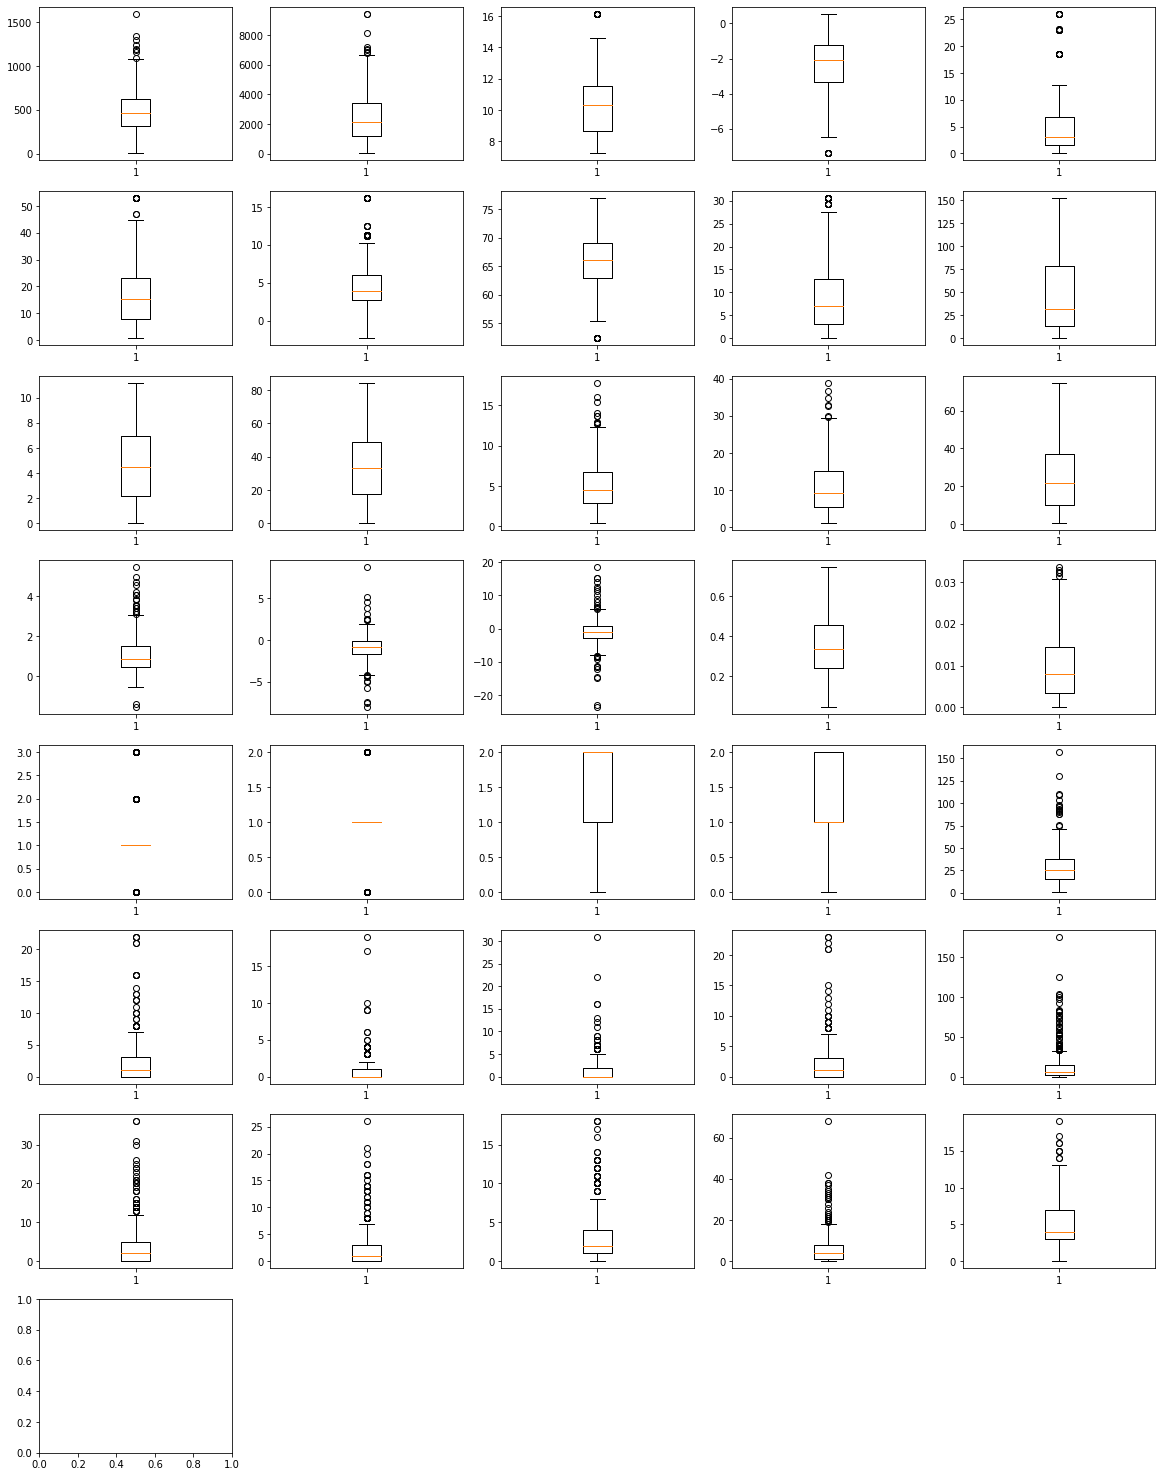

In [37]:
nrows= 9
ncols = 5
count=1
plt.figure(figsize=(20,30))
for c in columns:
    plt.subplot(nrows, ncols, count)
    plt.boxplot(df[c])
    count +=1
plt.show

TypeError: 'NoneType' object is not iterable

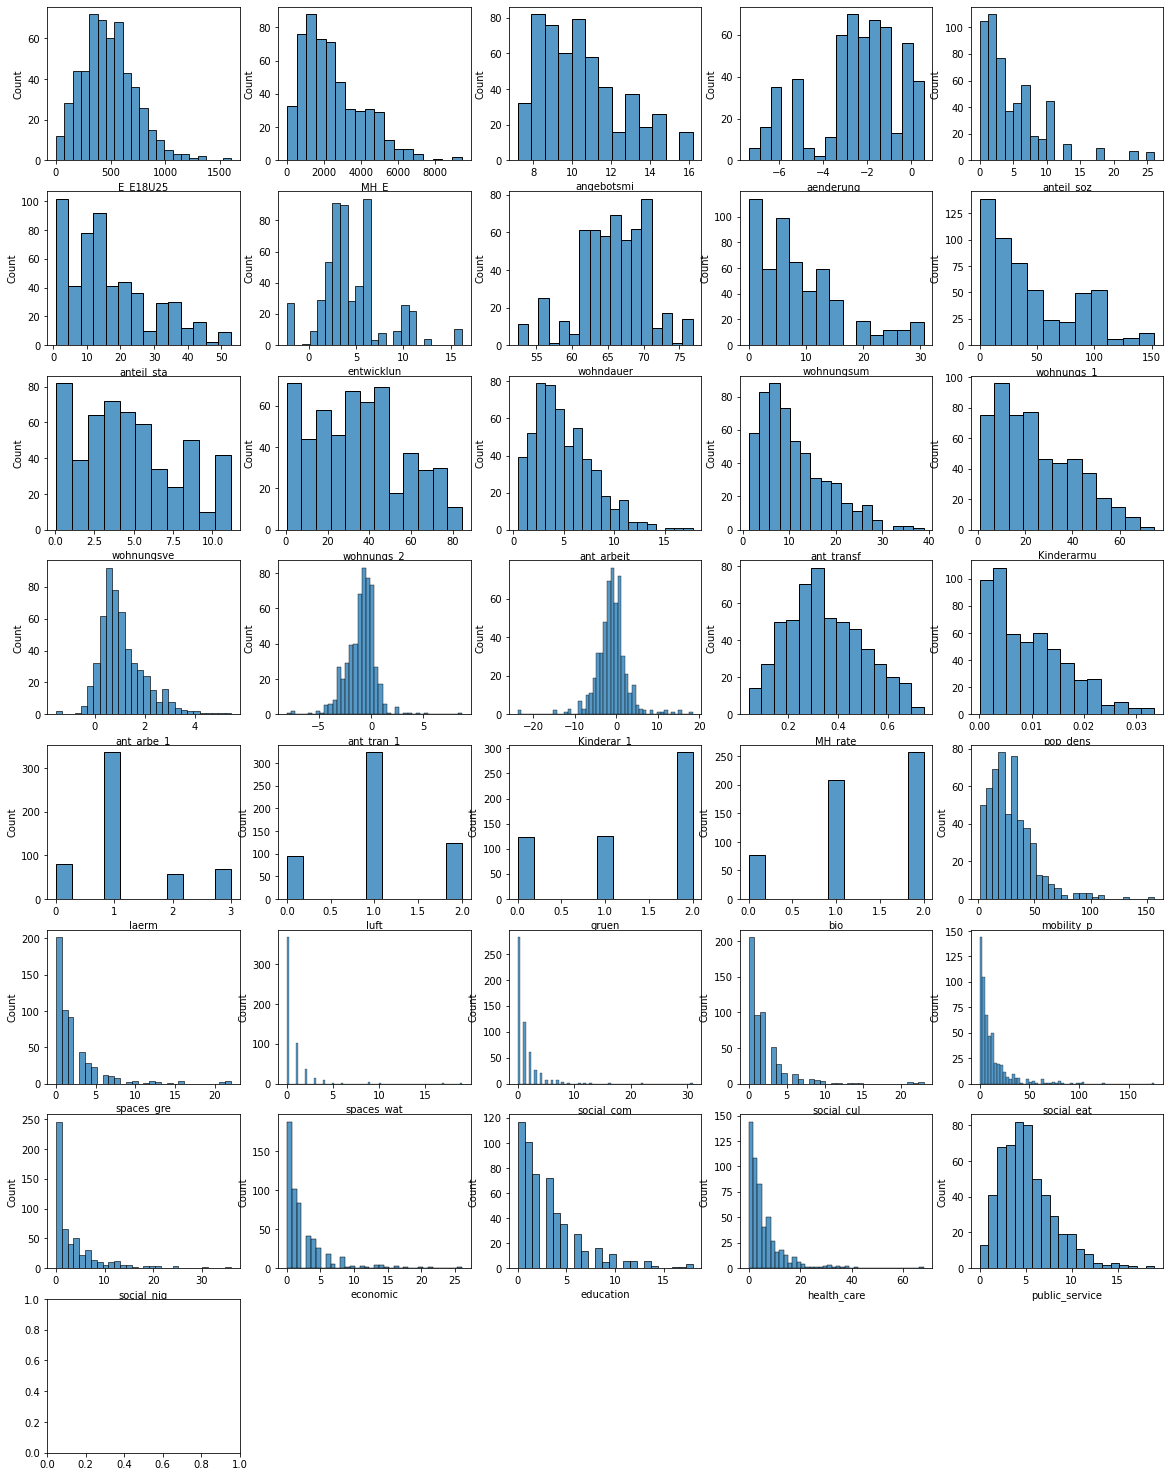

In [38]:
nrows= 9
ncols = 5
count=1
plt.figure(figsize=(20,30))
for c in columns:
    plt.subplot(nrows, ncols, count)
    sns.histplot(df[c])
    count +=1
plt.show

### Perform permutation
from sklearn.inspection import permutation_importance
- fit model 

model = LogisticRegression().fit(X,y)
- Perform permutation

permutation_score = permutation_importance(model, X,y, n_repeats=100)
- Unstack results, put in df

importance_df = pd.DataFrame(np.vstack((X.columns,permutation_score.importances_mean)).T)
importance_df.columns=['feature','feature importance']

- Order by importance

importance_df.sort_values(by="feature importance", ascending = False, inplace=True)
importance_df

**remove feature that have lower feature importance, run the validation score to test the reduced feature**